In [1]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

import os
import sys
import copy 
from time import time

from astropy.table import Table, vstack

import numpy as np 
import matplotlib.pyplot as plt
    
import matplotlib.mlab as ml
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator

from astroML.stats import binned_statistic_2d

from cap_loess_2d import loess_2d
from cap_plot_velfield import plot_velfield

from mpl_toolkits.axes_grid1 import make_axes_locatable

%config InlineBackend.figure_format='retina'
plt.rcParams['figure.dpi'] = 100.0
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12.0
plt.rc('text', usetex=True)

from hsc_massive import \
    s16a_path, \
    sample_selection, \
    prepare_sed, \
    catalog_summary, \
    mass_function, \
    smhm, \
    plotting

In [2]:
def show_smf(smf_list, label_list=None, text=None, loc=1,
             legend_fontsize=20):
    """Plot stellar mass functions."""
    fig = plt.figure(figsize=(7, 6))
    fig.subplots_adjust(left=0.17, right=0.994, 
                        bottom=0.12, top=0.994,
                        wspace=0.00, hspace=0.00)
    ax1 = fig.add_subplot(111)

    ax1.grid(linestyle='--', linewidth=2, alpha=0.5, zorder=0)
    
    m_list = ['o', '+', 's', 'h', 'x', 'H', '8', 'v', '<', '>']
    s_list = [15, 30, 20, 20, 30, 15, 15, 20, 20, 20]
    a_list = [0.4, 0.25, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3]
    c_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
    if label_list is not None:
        assert len(smf_list) == len(label_list)
    
    for ii, smf in enumerate(smf_list):
        if label_list is not None:
            label_use = label_list[ii]
        else:
            label_use = '__no_lable__'
        ax1.fill_between(smf['logm_mean'], 
                         np.log10(smf['smf_low']), 
                         np.log10(smf['smf_upp']), 
                         alpha=a_list[ii], 
                         facecolor=c_list[ii],
                         label=label_use)
        ax1.scatter(smf['logm_mean'], 
                    np.log10(smf['smf']), 
                    marker=m_list[ii], c=c_list[ii], 
                    s=s_list[ii], label='__no_label')

    ax1.set_xlim(11.19, 12.35)
    ax1.set_ylim(-7.9, -2.4)

    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)

    ax1.legend(fontsize=legend_fontsize, loc=loc)

    ax1.set_xlabel(r'$\log (M_{\star}/M_{\odot})$',
                   fontsize=25)
    ax1.set_ylabel((r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ $'
                    r'$[{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$'),
                   size=25)
    if text is not None:
        ax1.text(11.26, -7.4, text, fontsize=30)
        
    return fig

### HSC observations

In [3]:
hsc_smf_dir = '../data/s16a_massive_wide2/smf/'
hsc_dir = '../data/s16a_massive_wide2/'

hsc_smf_m100 = Table(np.load(os.path.join(hsc_smf_dir, 's16a_wide2_massive_smf_m100.npy')))
hsc_smf_m10 = Table(np.load(os.path.join(hsc_smf_dir, 's16a_wide2_massive_smf_m10.npy')))
hsc_smf_m15 = Table(np.load(os.path.join(hsc_smf_dir, 's16a_wide2_massive_smf_m15.npy')))
hsc_smf_m25 = Table(np.load(os.path.join(hsc_smf_dir, 's16a_wide2_massive_smf_m25.npy')))

hsc_mass = Table.read(os.path.join(hsc_dir, 's16a_wide2_massive_fsps1_imgsub_use_short.fits'))

hsc_use = hsc_mass[(hsc_mass['logm_100'] > 11.2)]

### UM SMDPL predictions

In [4]:
um_smdpl_box = 400.0 # Mpc 
um_smdpl_h0 = 0.667 
um_smdpl_vol = np.power(um_smdpl_box / um_smdpl_h0, 3.0)

print("# Volume of the UniverseMachine model: %d Mpc" % um_smdpl_vol)

# Volume of the UniverseMachine model: 215676323 Mpc


In [5]:
um_smdpl_dir = '/Users/song/astro5/massive/dr16a/um2/um2_new/um_smdpl_small'

um_smdpl_new_cen = Table(np.load(os.path.join(um_smdpl_dir, 
                                              'sfr_catalog_insitu_exsitu_0.712400_final.npz'))['centrals'])
um_smdpl_new_sat = Table(np.load(os.path.join(um_smdpl_dir, 
                                              'sfr_catalog_insitu_exsitu_0.712400_final.npz'))['satellites'])
um_smdpl_new = vstack([um_smdpl_new_cen, um_smdpl_new_sat])

In [49]:
sm_mask_new = ((np.log10(um_smdpl_new['sm'] + 
                         um_smdpl_new['icl']) >= 11.15) &
               (np.log10(um_smdpl_new['sm'] + 
                         um_smdpl_new['icl']) <= 12.5) &
               (np.log10(um_smdpl_new['sm']) >= 8.5) &
               (np.log10(um_smdpl_new['m']) >= 11.2))

um_smdpl_use = um_smdpl_new[sm_mask_new]
print(len(um_smdpl_use))

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


61239


#### Halo mass trend on the M_tot - M_ins plane

In [59]:
xx = np.log10(um_smdpl_use['sm'] + um_smdpl_use['icl'])
yy = np.log10(um_smdpl_use['sm'])
zz = np.log10(um_smdpl_use['m'])

xMin, xMax = np.nanmin(xx), np.nanmax(xx)
yMin, yMax = np.nanmin(yy), np.nanmax(yy)
zMin, zMax = np.nanmin(zz), np.nanmax(zz)
print(xMin, xMax, yMin, yMax, zMin, zMax)

zz_count, xedges, yedges = binned_statistic_2d(xx, yy, zz,
                                               'count', 
                                               bins=50)

zz_median, xedges, yedges = binned_statistic_2d(xx, yy, zz,
                                                np.nanmedian, 
                                                bins=50)

zz_sigma, xedges, yedges = binned_statistic_2d(xx, yy, zz,
                                               np.nanstd, 
                                               bins=50)
xcen = (xedges[0:-2] + xedges[1:-1]) / 2
ycen = (yedges[0:-2] + yedges[1:-1]) / 2

#sigz = zz * 0.0 + 0.02
#zout, wout = loess_2d(xx, yy, zz, degree=1, 
#                      sigz=sigz)

(11.150019201915148, 12.485820763530825, 8.5915098089946547, 11.943197630068926, 11.200576926754849, 15.104828403653656)


/usr/local/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:990: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in log10


(9.2, 11.99)

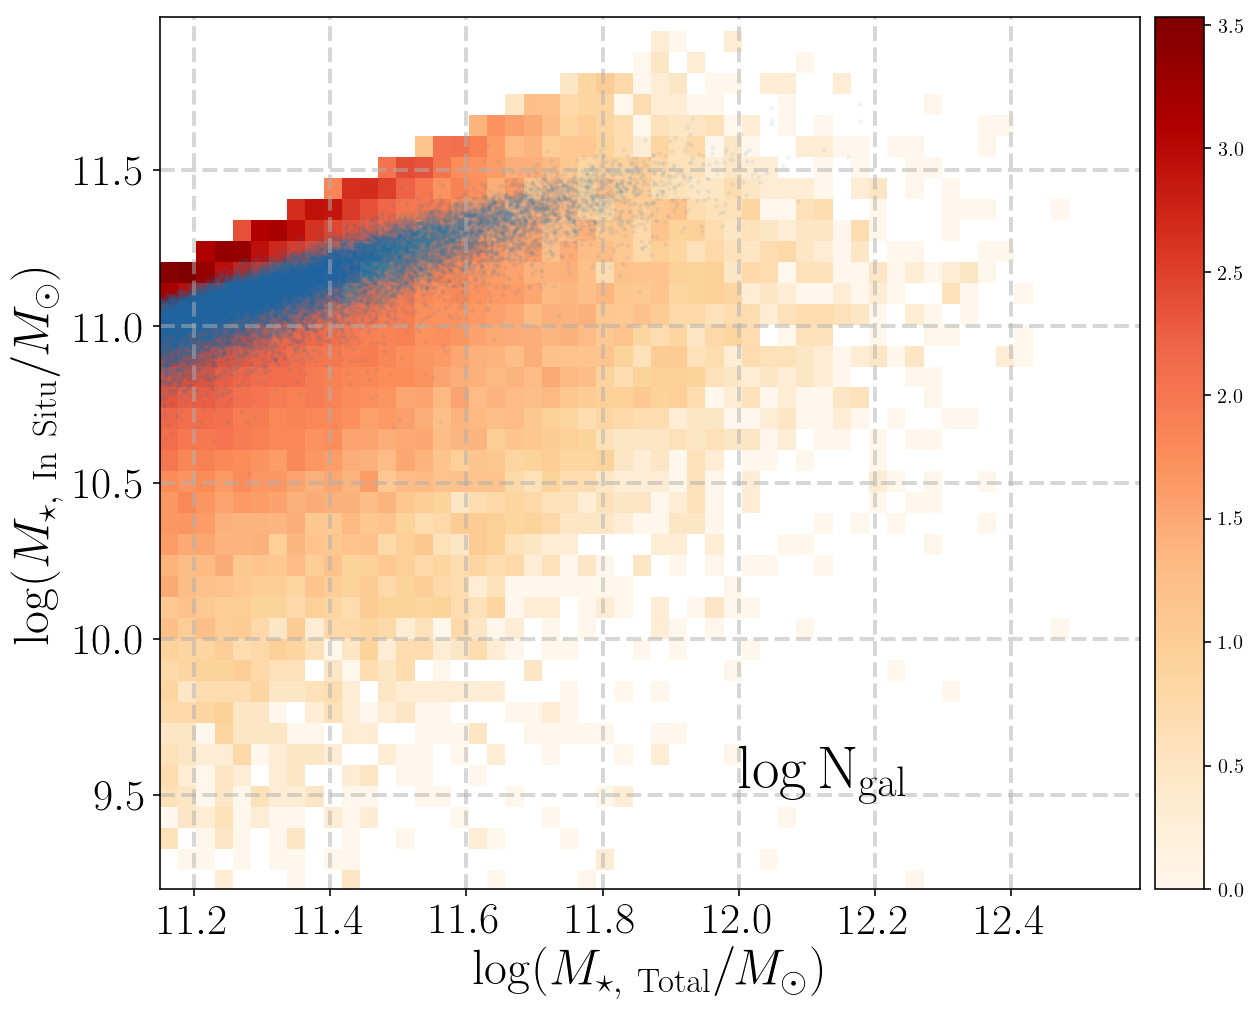

In [77]:
# --------------------------------------------------------------------------------------- #
xtickFormat='$\mathbf{%4.1f}$'
ytickFormat='$\mathbf{%4.1f}$'

ORG = plotting.ORG
BLK = plotting.BLK

nColors = 30
nTicks = 10


# --------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(9, 7))
fig.subplots_adjust(left=0.19, right=0.995, 
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.5, zorder=0)

HM = ax1.imshow(np.log10(zz_count.T), origin='lower',
                extent=[xedges[0], xedges[-1], 
                        yedges[0], yedges[-1]],
                aspect='auto', interpolation='nearest', 
                cmap=ORG)


ax1.set_xlabel('$\log (M_{\star,\ \mathrm{Total}}/M_{\odot})$', size=25)
ax1.set_ylabel('$\log (M_{\star,\ \mathrm{In\ Situ}}/M_{\odot})$', size=25)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(22)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(22)
    
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
cTicks = MaxNLocator(nTicks).tick_values(0, 5)
cbar = plt.colorbar(HM, cax=cax, ticks=cTicks)
cbar.solids.set_edgecolor("face") 

ax1.scatter(hsc_mass['logm_100'],
            hsc_mass['logm_10'], s=2, alpha=0.05)

ax1.text(12.0, 9.5, r'$\log\mathrm{N_{gal}}$', size=30)
#ax1.text(11.55, 11.65, r'$\log (M_{\star,\ \mathrm{Halo}}/M_{\odot})$', size=40)

# --------------------------------------------------------------------------------------- #
## X, Y limits
ax1.set_xlim(11.15, 12.59)
ax1.set_ylim(9.2, 11.99)

(9.2, 11.99)

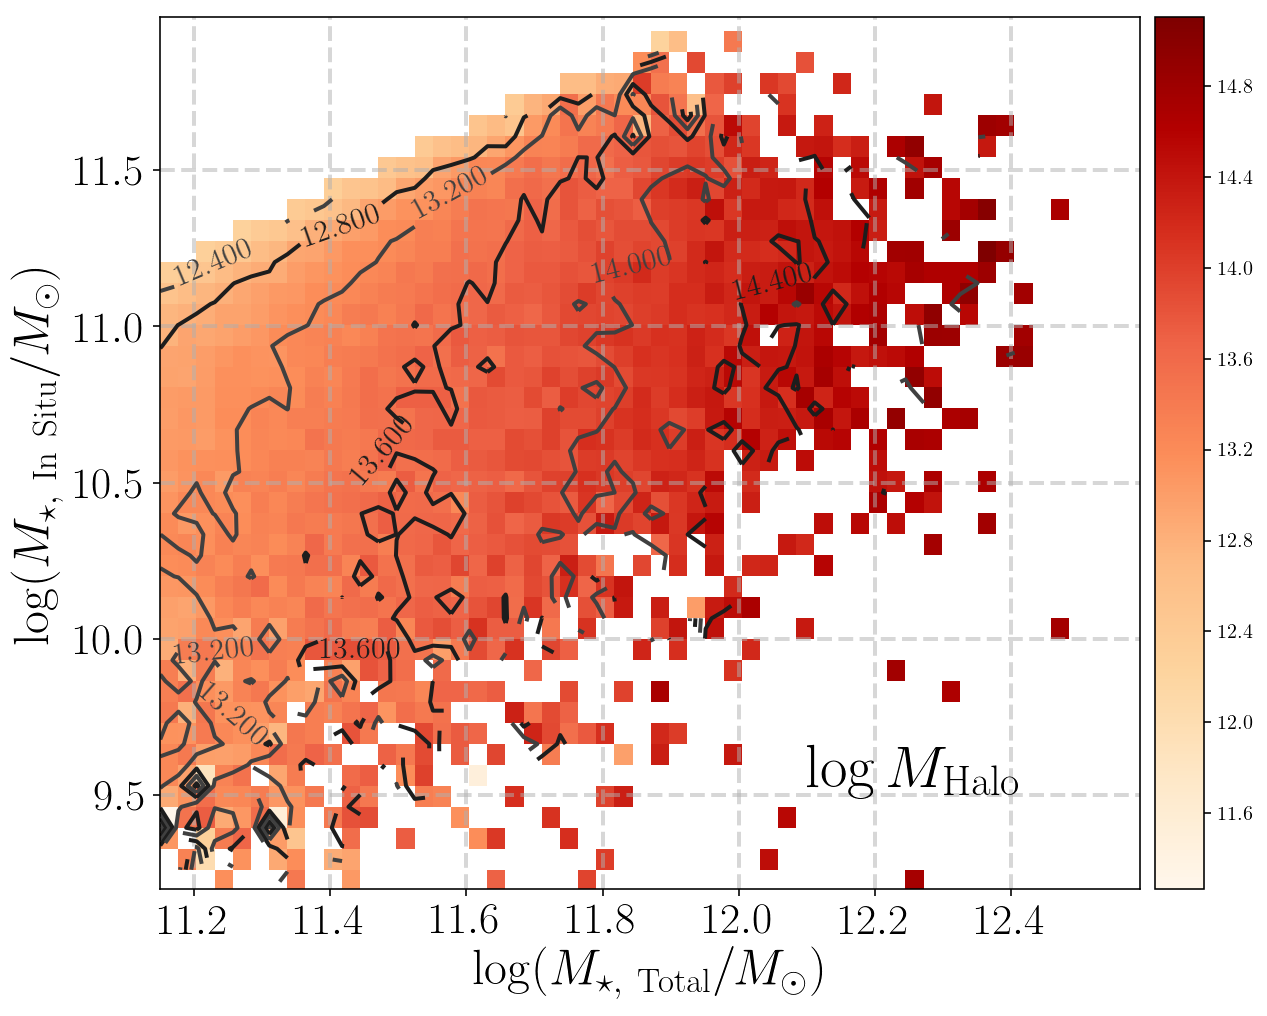

In [78]:
# --------------------------------------------------------------------------------------- #
xtickFormat='$\mathbf{%4.1f}$'
ytickFormat='$\mathbf{%4.1f}$'

ORG = plotting.ORG
BLK = plotting.BLK

nColors = 30
nTicks = 10

# --------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(9, 7))
fig.subplots_adjust(left=0.19, right=0.995, 
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.5, zorder=0)

HM = ax1.imshow(zz_median.T, origin='lower',
                extent=[xedges[0], xedges[-1], 
                        yedges[0], yedges[-1]],
                aspect='auto', interpolation='nearest', 
                cmap=ORG)

CT = ax1.contour(xedges[:-1], yedges[:-1], zz_median.T, 
                 10, linewidths=2.0, 
                 colors=[BLK(0.8), BLK(0.9)], 
                 extend='neither')
ax1.clabel(CT, inline=1, fontsize=15)

ax1.set_xlabel('$\log (M_{\star,\ \mathrm{Total}}/M_{\odot})$', size=25)
ax1.set_ylabel('$\log (M_{\star,\ \mathrm{In\ Situ}}/M_{\odot})$', size=25)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(22)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(22)
    
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
cTicks = MaxNLocator(nTicks).tick_values(zMin, zMax)
cbar = plt.colorbar(HM, cax=cax, ticks=cTicks)
cbar.solids.set_edgecolor("face") 

ax1.text(12.1, 9.5, r'$\log M_{\mathrm{Halo}}$', size=30)

# --------------------------------------------------------------------------------------- #
## X, Y limits
ax1.set_xlim(11.15, 12.59)
ax1.set_ylim(9.2, 11.99)

(9.2, 11.99)

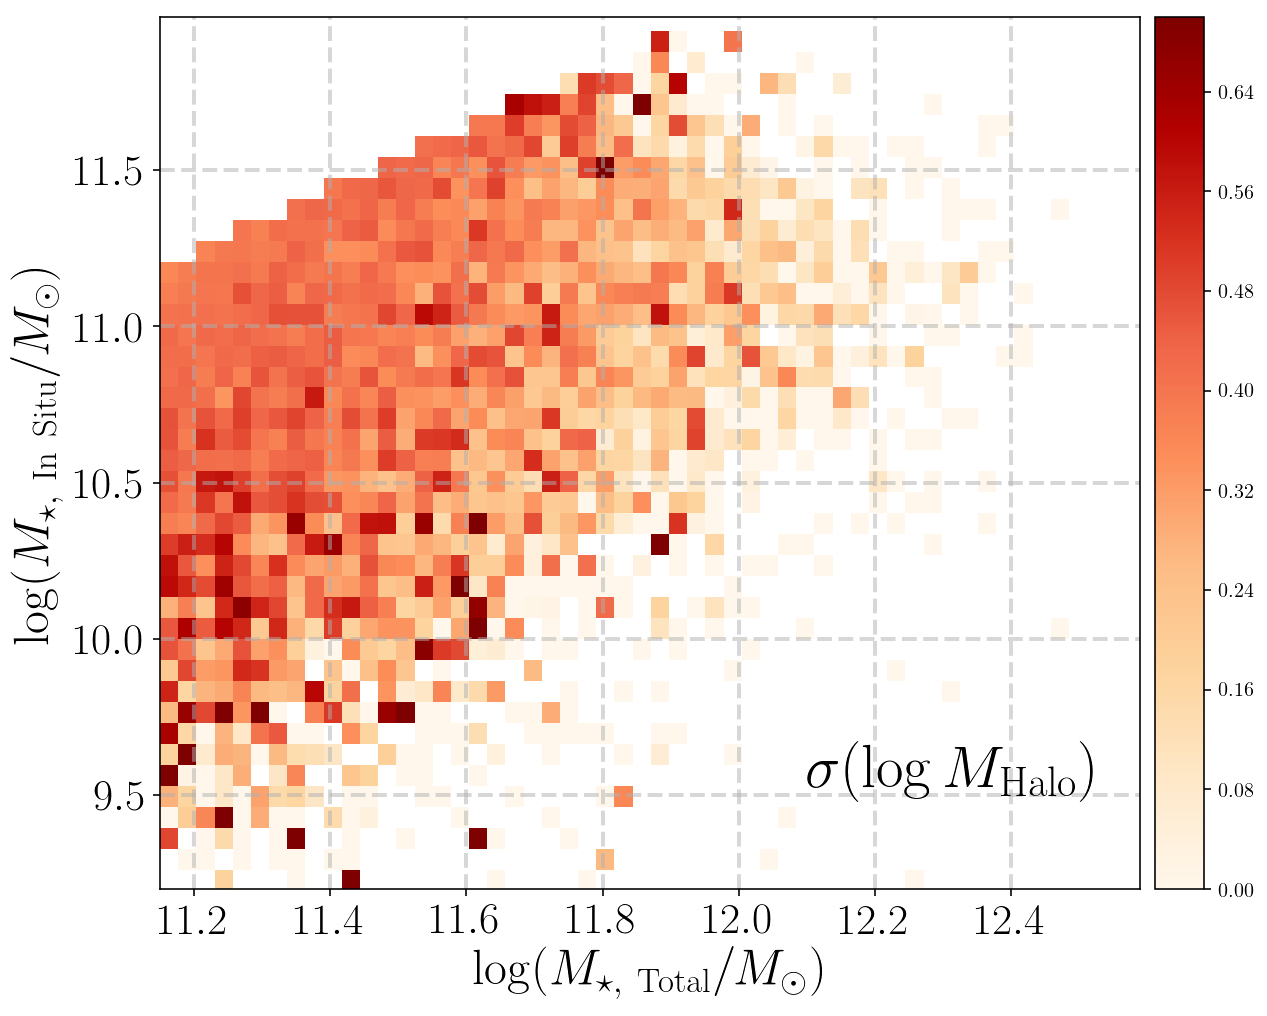

In [81]:
# --------------------------------------------------------------------------------------- #
xtickFormat='$\mathbf{%4.1f}$'
ytickFormat='$\mathbf{%4.1f}$'

ORG = plotting.ORG
BLK = plotting.BLK

nColors = 30
nTicks = 10

# --------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(9, 7))
fig.subplots_adjust(left=0.19, right=0.995, 
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.5, zorder=0)

HM = ax1.imshow(zz_sigma.T, origin='lower',
                extent=[xedges[0], xedges[-1], 
                        yedges[0], yedges[-1]],
                aspect='auto', interpolation='nearest', 
                cmap=ORG, vmax=0.7)

ax1.set_xlabel('$\log (M_{\star,\ \mathrm{Total}}/M_{\odot})$', size=25)
ax1.set_ylabel('$\log (M_{\star,\ \mathrm{In\ Situ}}/M_{\odot})$', size=25)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(22)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(22)
    
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
cTicks = MaxNLocator(nTicks).tick_values(np.nanmin(zz_sigma),
                                         0.7)
cbar = plt.colorbar(HM, cax=cax, ticks=cTicks)
cbar.solids.set_edgecolor("face") 

ax1.text(12.1, 9.5, r'$\sigma(\log M_{\mathrm{Halo}})$', size=30)

# --------------------------------------------------------------------------------------- #
## X, Y limits
ax1.set_xlim(11.15, 12.59)
ax1.set_ylim(9.2, 11.99)

#### Toy model

In [125]:
def frac_mhalo_depend(mh, para_a, para_b):
    frac = (para_a * np.log10(mh) + para_b)
    frac = np.where(frac <= 0, 0.0, frac)
    frac = np.where(frac >= 1, 1.0, frac)
    
    return frac

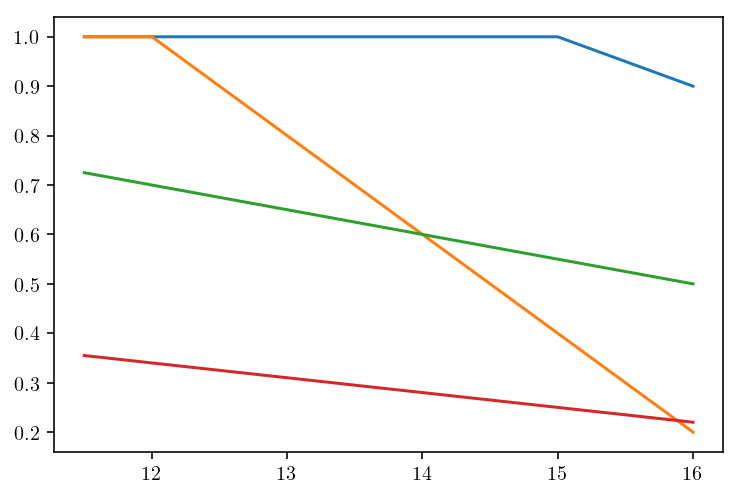

In [200]:
mh_test = 10.0 ** np.linspace(11.5, 16.0, 10)

plt.plot(np.log10(mh_test), frac_mhalo_depend(mh_test, -0.1, 2.5))
plt.plot(np.log10(mh_test), frac_mhalo_depend(mh_test, -0.2, 3.4))

plt.plot(np.log10(mh_test), frac_mhalo_depend(mh_test, -0.05, 1.3))
plt.plot(np.log10(mh_test), frac_mhalo_depend(mh_test, -0.03, 0.7))

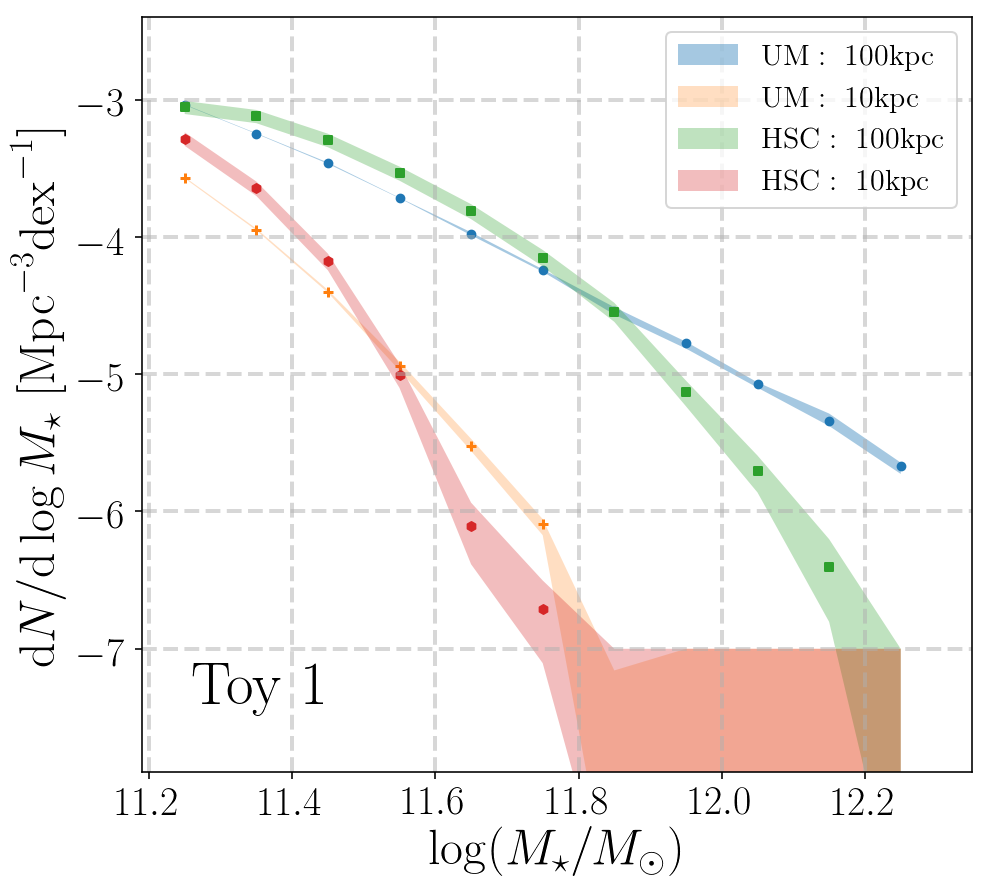

In [202]:
frac_ins_1 = frac_mhalo_depend(um_smdpl_use['sm'], -0.1, 2.5)
frac_exs_1 = frac_mhalo_depend(um_smdpl_use['sm'], -0.2, 3.7)

frac_ins_2 = frac_mhalo_depend(um_smdpl_use['sm'], -0.05, 1.3) 
frac_exs_2 = frac_mhalo_depend(um_smdpl_use['sm'], 0.01, 0.01) 

logms_um_100 = np.log10(frac_ins_1 * um_smdpl_use['sm'] + 
                        frac_exs_1 * um_smdpl_use['icl'])
logms_um_10  = np.log10(frac_ins_2 * um_smdpl_use['sm'] + 
                        frac_exs_2 * um_smdpl_use['icl'])

um_smf_100 = mass_function.get_smf_bootstrap(
    logms_um_100, um_smdpl_vol, 11, 11.2, 12.3, n_boots=10
)

um_smf_10 = mass_function.get_smf_bootstrap(
    logms_um_10, um_smdpl_vol, 11, 11.2, 12.3, n_boots=10
)

smf_mcmod_fig = show_smf([um_smf_100, um_smf_10, hsc_smf_m100, hsc_smf_m10],
                         [r'$\mathrm{UM:\ 100kpc}$', 
                          r'$\mathrm{UM:\ 10kpc}$', 
                          r'$\mathrm{HSC:\ 100kpc}$',
                          r'$\mathrm{HSC:\ 10kpc}$'],
                         text=r'$\mathrm{Toy\ 1}$', 
                         legend_fontsize=15)

In [197]:
xx = logms_um_100
yy = logms_um_10
zz = np.log10(um_smdpl_use['m'])

xMin, xMax = np.nanmin(xx), np.nanmax(xx)
yMin, yMax = np.nanmin(yy), np.nanmax(yy)
zMin, zMax = np.nanmin(zz), np.nanmax(zz)
print(xMin, xMax, yMin, yMax, zMin, zMax)

zz_count, xedges, yedges = binned_statistic_2d(xx, yy, zz,
                                               'count', 
                                               bins=50)

zz_median, xedges, yedges = binned_statistic_2d(xx, yy, zz,
                                                np.nanmedian, 
                                                bins=50)

zz_sigma, xedges, yedges = binned_statistic_2d(xx, yy, zz,
                                               np.nanstd, 
                                               bins=50)
xcen = (xedges[0:-2] + xedges[1:-1]) / 2
ycen = (yedges[0:-2] + yedges[1:-1]) / 2

(11.150019201915148, 12.485820763530825, 10.429013429275253, 11.892692179223879, 11.200576926754849, 15.104828403653656)


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in log10


(10.0, 11.99)

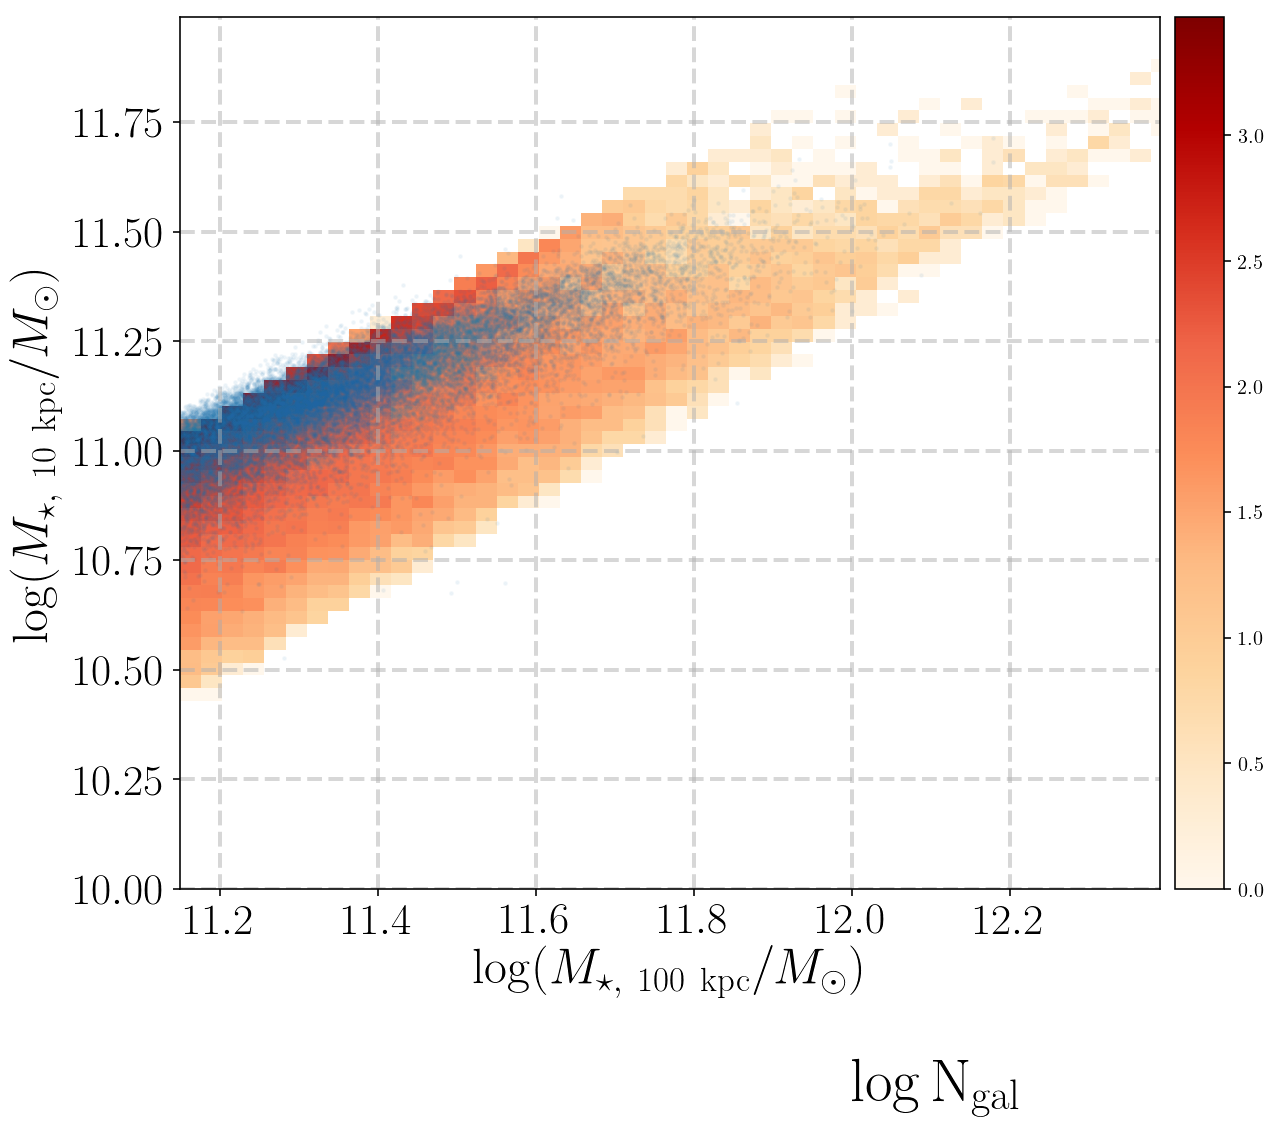

In [198]:
# --------------------------------------------------------------------------------------- #
xtickFormat='$\mathbf{%4.1f}$'
ytickFormat='$\mathbf{%4.1f}$'

ORG = plotting.ORG
BLK = plotting.BLK

nColors = 30
nTicks = 10


# --------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(9, 7))
fig.subplots_adjust(left=0.19, right=0.995, 
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.5, zorder=0)

HM = ax1.imshow(np.log10(zz_count.T), origin='lower',
                extent=[xedges[0], xedges[-1], 
                        yedges[0], yedges[-1]],
                aspect='auto', interpolation='nearest', 
                cmap=ORG)


ax1.set_xlabel('$\log (M_{\star,\ \mathrm{100\ kpc}}/M_{\odot})$', size=25)
ax1.set_ylabel('$\log (M_{\star,\ \mathrm{10\ kpc}}/M_{\odot})$', size=25)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(22)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(22)
    
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
cTicks = MaxNLocator(nTicks).tick_values(0, 5)
cbar = plt.colorbar(HM, cax=cax, ticks=cTicks)
cbar.solids.set_edgecolor("face") 

ax1.scatter(hsc_mass['logm_100'],
            hsc_mass['logm_10'], s=2, alpha=0.05)

ax1.text(12.0, 9.5, r'$\log\mathrm{N_{gal}}$', size=30)
#ax1.text(11.55, 11.65, r'$\log (M_{\star,\ \mathrm{Halo}}/M_{\odot})$', size=40)

# --------------------------------------------------------------------------------------- #
## X, Y limits
ax1.set_xlim(11.15, 12.39)
ax1.set_ylim(10.0, 11.99)

(10.0, 11.99)

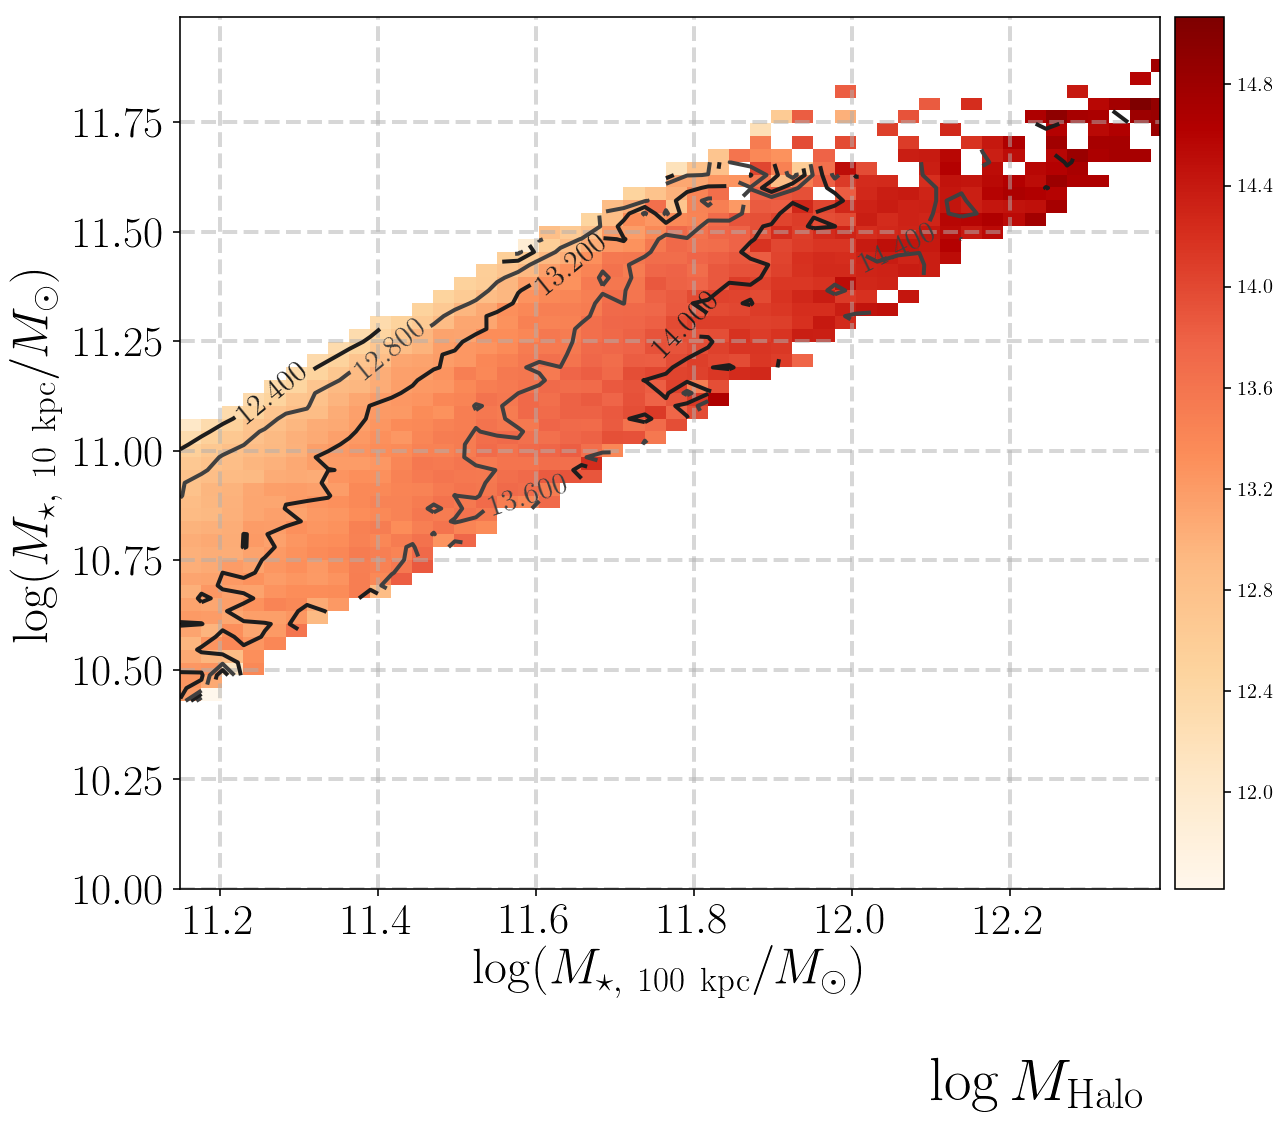

In [199]:
# --------------------------------------------------------------------------------------- #
xtickFormat='$\mathbf{%4.1f}$'
ytickFormat='$\mathbf{%4.1f}$'

ORG = plotting.ORG
BLK = plotting.BLK

nColors = 30
nTicks = 10

# --------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(9, 7))
fig.subplots_adjust(left=0.19, right=0.995, 
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.5, zorder=0)

HM = ax1.imshow(zz_median.T, origin='lower',
                extent=[xedges[0], xedges[-1], 
                        yedges[0], yedges[-1]],
                aspect='auto', interpolation='nearest', 
                cmap=ORG)

CT = ax1.contour(xedges[:-1], yedges[:-1], zz_median.T, 
                 10, linewidths=2.0, 
                 colors=[BLK(0.8), BLK(0.9)], 
                 extend='neither')
ax1.clabel(CT, inline=1, fontsize=15)

ax1.set_xlabel('$\log (M_{\star,\ \mathrm{100\ kpc}}/M_{\odot})$', size=25)
ax1.set_ylabel('$\log (M_{\star,\ \mathrm{10\ kpc}}/M_{\odot})$', size=25)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(22)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(22)
    
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
cTicks = MaxNLocator(nTicks).tick_values(zMin, zMax)
cbar = plt.colorbar(HM, cax=cax, ticks=cTicks)
cbar.solids.set_edgecolor("face") 

ax1.text(12.1, 9.5, r'$\log M_{\mathrm{Halo}}$', size=30)

# --------------------------------------------------------------------------------------- #
## X, Y limits
ax1.set_xlim(11.15, 12.39)
ax1.set_ylim(10.0, 11.99)

(10.0, 11.99)

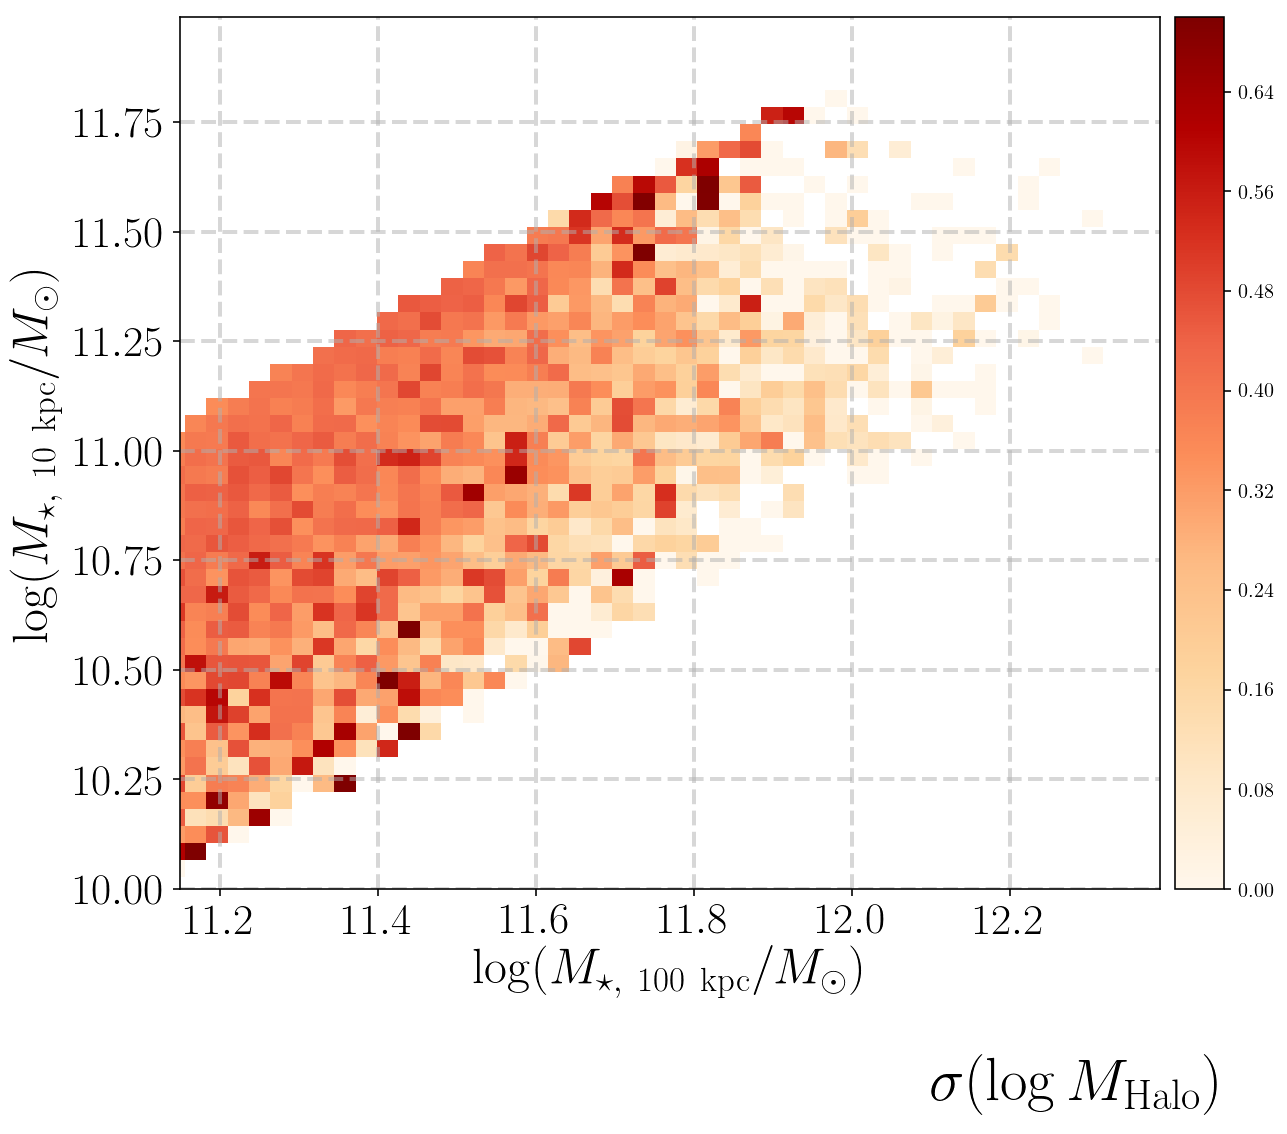

In [108]:
# --------------------------------------------------------------------------------------- #
xtickFormat='$\mathbf{%4.1f}$'
ytickFormat='$\mathbf{%4.1f}$'

ORG = plotting.ORG
BLK = plotting.BLK

nColors = 30
nTicks = 10

# --------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(9, 7))
fig.subplots_adjust(left=0.19, right=0.995, 
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.5, zorder=0)

HM = ax1.imshow(zz_sigma.T, origin='lower',
                extent=[xedges[0], xedges[-1], 
                        yedges[0], yedges[-1]],
                aspect='auto', interpolation='nearest', 
                cmap=ORG, vmax=0.7)

ax1.set_xlabel('$\log (M_{\star,\ \mathrm{100\ kpc}}/M_{\odot})$', size=25)
ax1.set_ylabel('$\log (M_{\star,\ \mathrm{10\ kpc}}/M_{\odot})$', size=25)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(22)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(22)
    
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
cTicks = MaxNLocator(nTicks).tick_values(np.nanmin(zz_sigma),
                                         0.7)
cbar = plt.colorbar(HM, cax=cax, ticks=cTicks)
cbar.solids.set_edgecolor("face") 

ax1.text(12.1, 9.5, r'$\sigma(\log M_{\mathrm{Halo}})$', size=30)

# --------------------------------------------------------------------------------------- #
## X, Y limits
ax1.set_xlim(11.15, 12.39)
ax1.set_ylim(10.0, 11.99)